<a href="https://colab.research.google.com/github/ruany-doehnert/Deforestation_Amazon/blob/main/data_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install and authenticate Earth Engine in Colab
# !pip install earthengine-api --quiet
# !pip install rasterio
import rasterio
import numpy as np
import pandas as pd
import ee

In [3]:
ee.Authenticate()
ee.Initialize(project='amazon-deforestation-462101')

In [4]:
# Load the Hansen Global Forest Change dataset
gfc = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# Example: Select tree cover for the year 2000 and visualize as a numpy array
region = ee.Geometry.BBox(-60, -10, -59, -9)  # Example: small region in the Amazon

# Get tree cover band (percent canopy cover in 2000)
treecover2000 = gfc.select('treecover2000')

# Sample the image as a numpy array for the region
url = treecover2000.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'region': region
})

print("Download URL for treecover2000 (small region):", url)

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for UMD/hansen/global_forest_change_2022_v1_10! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10

  warnings.warn(warning, category=DeprecationWarning)


Download URL for treecover2000 (small region): https://earthengine.googleapis.com/v1/projects/amazon-deforestation-462101/thumbnails/0ecf95e4bc05862e9b46fff4e522b3a4-9ad46742e38eb47b3eaaa3ad936f6870:getPixels


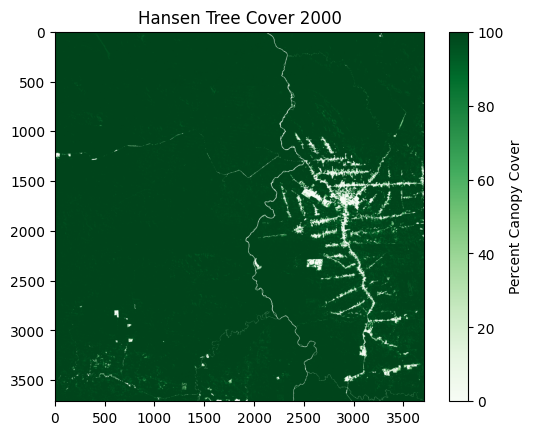

In [8]:
import rasterio
import matplotlib.pyplot as plt

# Replace 'your_file.tif' with the actual filename
file_path = '/content/global_forest_change_2022_v1_10.treecover2000.tif'

with rasterio.open(file_path) as src:
    img = src.read(1)
    plt.imshow(img, cmap='Greens')
    plt.title('Hansen Tree Cover 2000')
    plt.colorbar(label='Percent Canopy Cover')
    plt.show()

In [11]:
file_path = '/content/global_forest_change_2022_v1_10.treecover2000.tif'  # Update with your filename

with rasterio.open(file_path) as src:
    img = src.read(1)
    # Get coordinates for each pixel
    rows, cols = np.where(~src.read_masks(1)==0)
    xs, ys = src.xy(rows, cols)
    # Flatten arrays
    xs = np.array(xs)
    ys = np.array(ys)
    values = img[rows, cols]
    # Label: 1 = forest, 0 = non-forest
    labels = (values > 30).astype(int)

In [12]:
df = pd.DataFrame({
    'x': xs,
    'y': ys,
    'treecover': values,
    'label': labels
})
print(df.head())

           x         y  treecover  label
0 -59.999870 -8.999906        100      1
1 -59.999601 -8.999906        100      1
2 -59.999331 -8.999906        100      1
3 -59.999062 -8.999906        100      1
4 -59.998792 -8.999906        100      1


In [13]:
df.to_csv('forest_ml_dataset.csv', index=False)
print("✅ Dataset saved as forest_ml_dataset.csv")

✅ Dataset saved as forest_ml_dataset.csv
